In [103]:
print("hello world")

hello world


In [104]:
import pandas as pd

# Specify the path to the u.data file
file_path = '/Users/tarunvallabhaneni/MPCS Classes/Math of ML/mml-project/Final Project/data/ml-100k/u.data'

# Load the dataset into a DataFrame
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(file_path, sep='\t', names=column_names)
ratings.drop('timestamp', axis=1, inplace=True)

# Display the first few rows
print(ratings.head())


   user_id  item_id  rating
0      196      242       3
1      186      302       3
2       22      377       1
3      244       51       2
4      166      346       1


In [116]:

# convert to matrix R
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

user_item_matrix = user_item_matrix.fillna(0)

# print info
print(user_item_matrix.info())


total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
non_zero_elems = (user_item_matrix != 0).sum().sum()
sparsity = 1 - (non_zero_elems / total_elements)
print(f"\nSparsity of the matrix is {sparsity:.2%}")



<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 1 to 943
Columns: 1682 entries, 1 to 1682
dtypes: float64(1682)
memory usage: 12.1 MB
None

Sparsity of the matrix is 93.70%


In [117]:
import numpy as np
matrix_np = user_item_matrix.to_numpy()
print(matrix_np)

nonzero_indices = matrix_np.nonzero()
nonzero_count = np.count_nonzero(matrix_np)
print(nonzero_indices)
print(nonzero_count)


[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
(array([  0,   0,   0, ..., 942, 942, 942]), array([   0,    1,    2, ..., 1187, 1227, 1329]))
100000


# Training Class

In [118]:
from tqdm import tqdm
class GD:
    def __init__(self, R, k, learning_rate=0.001, reg_param=0.01, epochs=10, batch_size=100):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.k = k
        self.learning_rate = learning_rate
        self.reg_param = reg_param  
        self.num_epochs = epochs
        self.rows, self.cols = self.R.nonzero()
        self.batch_size = batch_size
        
        # Calculate rating mean and std for normalization
        self.rating_mean = np.mean(R[R.nonzero()])
        self.rating_std = np.std(R[R.nonzero()])
        
        # Initialize 
        self.U = np.random.normal(0, 0.1, size=(self.num_users, self.k))
        self.V = np.random.normal(0, 0.1, size=(self.num_items, self.k))
        
    def normalize_rating(self, rating):
        return (rating - self.rating_mean) / self.rating_std
        
    def denormalize_rating(self, normalized_rating):
        return (normalized_rating * self.rating_std) + self.rating_mean


    
    # def calculate_rmse(self, R):
    #     """Calculate RMSE"""
    #     rows, cols = R.nonzero()
    #     if len(rows) == 0:
    #         return float('inf')
            
    #     r_true = R[rows, cols]
    #     r_true_norm = self.normalize_rating(r_true)
    #     r_pred = np.sum(self.U[rows] * self.V[cols], axis=1)
        
    #     errors = r_true_norm - r_pred
    #     mse = np.mean(errors ** 2)
    #     rmse = np.sqrt(mse)
    #     return mse, rmse
    
    def calculate_rmse(self, R):
        """Calculate RMSE on the original rating scale"""
        rows, cols = R.nonzero()
        if len(rows) == 0:
            return float('inf')
            
        r_true = R[rows, cols]
        r_pred = np.sum(self.U[rows] * self.V[cols], axis=1)
        r_pred_denorm = self.denormalize_rating(r_pred)  # Denormalize predictions
        
        # Calculate errors on the original scale
        errors = r_true - r_pred_denorm
        mse = np.mean(errors ** 2)
        rmse = np.sqrt(mse)
        return mse, rmse


        
    def train(self, val_matrix=None):
        indices = list(zip(self.rows, self.cols))

        train_rmse_history = []
        val_rmse_history = [] if val_matrix is not None else None

        
        for epoch in range(self.num_epochs):
            np.random.shuffle(indices)
            
            for batch_start in range(0, len(indices), self.batch_size):
                batch_indices = indices[batch_start:batch_start+self.batch_size]
                
                user_indices = np.array([i for i, _ in batch_indices])
                item_indices = np.array([j for _, j in batch_indices])

                # get the batch for U and V
                U_batch = self.U[user_indices]
                V_batch = self.V[item_indices]

                # get true ratings and normalize
                r_true = self.R[user_indices, item_indices]
                r_true_norm = self.normalize_rating(r_true)

                # compute predictions and errors
                r_pred = np.sum(U_batch * V_batch, axis=1)
                errors = r_true_norm - r_pred

                # compute gradients
                # broadcast to shape (batch_size, k) for element-wise multiplication
                U_grad = -2 * (errors[:, np.newaxis] * V_batch) + 2 * self.reg_param * U_batch
                V_grad = -2 * (errors[:, np.newaxis] * U_batch) + 2 * self.reg_param * V_batch

                # update parameters
                self.U[user_indices] -= self.learning_rate * U_grad
                self.V[item_indices] -= self.learning_rate * V_grad
            
            # calculate losses
            _, rmse_train = self.calculate_rmse(self.R)
            train_rmse_history.append(rmse_train)

            if val_matrix is not None:
                _, rmse_val = self.calculate_rmse(val_matrix)
                val_rmse_history.append(rmse_val)
        
        return train_rmse_history, val_rmse_history
            
            

# K Fold Cross Validation

In [145]:
from sklearn.model_selection import train_test_split


def prepare_cross_validation(R, n_folds=5, test_size=0.2, random_state=42):
    # Get observed (i, j) pairs from the matrix
    rows, cols = R.nonzero()
    data = list(zip(rows, cols))
    
    # Split data into train/val and test sets
    train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    
    # Create k folds
    def k_folds(data, k):
        np.random.shuffle(data)
        fold_size = len(data) // k
        leftover = len(data) % k
        
        folds = []
        start = 0
        for i in range(k):
            extra = 1 if i < leftover else 0
            end = start + fold_size + extra
            folds.append(data[start:end])
            start = end
        return folds
    
    folds = k_folds(train_val_data, n_folds)
    
    # Create test matrix
    test_matrix = np.zeros(R.shape)
    for i, j in test_data:
        test_matrix[i, j] = R[i, j]
        
    return folds, test_matrix

def train_with_cross_validation(R, folds, model_params):
    all_val_rmse = []
    # all_val_mse = []
    train_rmse_per_fold = []
    val_rmse_per_fold = []
    
    for fold_idx, fold in enumerate(folds):
        
        # Prepare validation data
        val_data = fold
        train_data = [point for idx, f in enumerate(folds) if idx != fold_idx for point in f]
        
        # Create validation matrix
        val_matrix = np.zeros(R.shape)
        for i, j in val_data:
            val_matrix[i, j] = R[i, j]
            
        # Create training matrix
        train_matrix = np.zeros(R.shape)
        for i, j in train_data:
            train_matrix[i, j] = R[i, j]
            
        # Train model
        model = GD(train_matrix, **model_params)
        train_rmse_history, val_rmse_history = model.train(val_matrix)
        train_rmse_per_fold.append(train_rmse_history)
        val_rmse_per_fold.append(val_rmse_history)
        
        # Store validation RMSE
        val_mse, val_rmse = model.calculate_rmse(val_matrix)
        assert val_rmse == val_rmse_history[-1]
        all_val_rmse.append(val_rmse_history[-1])
        # all_val_mse.append(val_mse)
    
    mean_train_rmse = np.mean(train_rmse_per_fold, axis=0)
    mean_val_rmse = np.mean(val_rmse_per_fold, axis=0)
    
    epochs = range(len(mean_train_rmse))
    print(epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_train_rmse, marker='o',label='Train RMSE')
    plt.plot(epochs, mean_val_rmse, marker='o', label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute average RMSE across all folds
    average_val_rmse = np.mean(all_val_rmse)
    # print(f"\nAverage Validation RMSE across all folds: {average_val_rmse:.4f}")
    
    return average_val_rmse

        
    


range(0, 20)


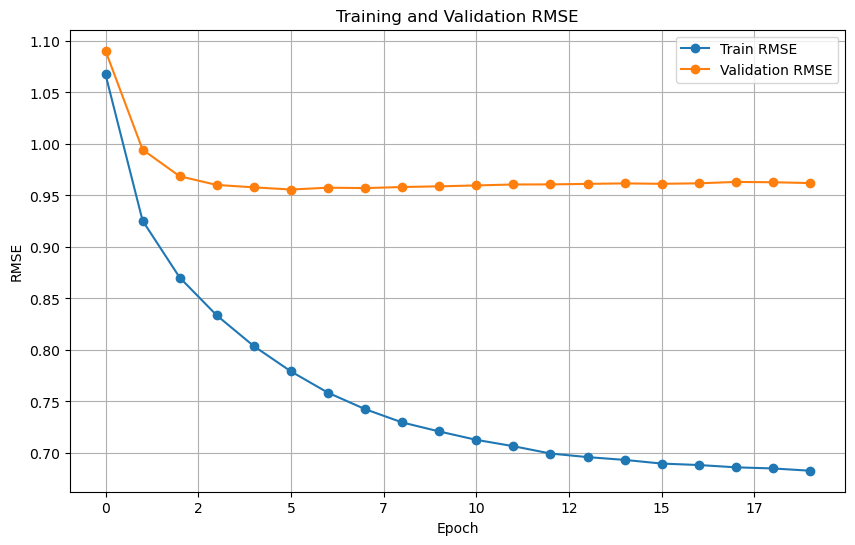


Mean RMSE across folds: 0.9620


In [146]:
folds, test_matrix = prepare_cross_validation(matrix_np, n_folds=5)
model_params = {
    'k': 30,
    'learning_rate': 0.05,  
    'reg_param': 0.1,       
    'epochs': 20,
    'batch_size': 100
}
rmse = train_with_cross_validation(matrix_np, folds, model_params)
print(f"\nMean RMSE across folds: {rmse:.4f}")




# Test Error

# Hyperparameter Tuning

In [124]:
import itertools
def hyperparameter_search(R, folds, hyperparams):
    best_val_loss = float('inf')
    best_hyperparams = None
    
    for param in hyperparams:
        model_params = {
            'k': param[0],
            'learning_rate': param[1],
            'reg_param': param[2],
            'epochs': param[3],
            'batch_size': 100
        }

        print(f"\nTraining with hyperparameter: {param}")
        
        
        mse, rmse = train_with_cross_validation(R, folds, model_params)
        
        if rmse < best_val_loss:
            best_val_loss = rmse
            best_hyperparams = param
            
    return best_hyperparams, best_val_loss


k_values = [10, 20, 30]
learning_rates = [0.01, 0.02]
reg_params = [0.05, 0.1,  0.2]
epochs = [20, 30]

hyperparam_combinations = list(itertools.product(k_values, learning_rates, reg_params, epochs))
len(hyperparam_combinations)

36

In [125]:
best_hyperparams, best_val_loss = hyperparameter_search(matrix_np, folds, hyperparam_combinations)


Training with hyperparameter: (10, 0.01, 0.05, 20)

Training with hyperparameter: (10, 0.01, 0.05, 30)

Training with hyperparameter: (10, 0.01, 0.1, 20)

Training with hyperparameter: (10, 0.01, 0.1, 30)

Training with hyperparameter: (10, 0.01, 0.2, 20)

Training with hyperparameter: (10, 0.01, 0.2, 30)

Training with hyperparameter: (10, 0.02, 0.05, 20)

Training with hyperparameter: (10, 0.02, 0.05, 30)

Training with hyperparameter: (10, 0.02, 0.1, 20)

Training with hyperparameter: (10, 0.02, 0.1, 30)

Training with hyperparameter: (10, 0.02, 0.2, 20)

Training with hyperparameter: (10, 0.02, 0.2, 30)

Training with hyperparameter: (20, 0.01, 0.05, 20)

Training with hyperparameter: (20, 0.01, 0.05, 30)

Training with hyperparameter: (20, 0.01, 0.1, 20)

Training with hyperparameter: (20, 0.01, 0.1, 30)

Training with hyperparameter: (20, 0.01, 0.2, 20)

Training with hyperparameter: (20, 0.01, 0.2, 30)

Training with hyperparameter: (20, 0.02, 0.05, 20)

Training with hyperpara

In [126]:
best_hyperparams, best_val_loss

((10, 0.01, 0.1, 30), 0.9436326122475391)

In [149]:
final_model_params = {
            'k': best_hyperparams[0],
            'learning_rate': best_hyperparams[1],
            'reg_param': best_hyperparams[2],
            'epochs': best_hyperparams[3],
            'batch_size': 100
        }


def combine_folds(folds, R):
    train_matrix = np.zeros(R.shape)
    for fold in folds:
        for i, j in fold:
            train_matrix[i, j] = R[i, j]
    return train_matrix

# Combine folds to create the final training matrix
final_train_matrix = combine_folds(folds, matrix_np)


final_model = GD(final_train_matrix, **final_model_params)

train_rmse, _ = final_model.train()

# Calculate test RMSE
test_mse, test_rmse = final_model.calculate_rmse(test_matrix)

print(f"Final Test MSE: {test_mse:.4f}")
print(f"Final Test RMSE: {test_rmse:.4f}")




Final Test MSE: 0.8731
Final Test RMSE: 0.9344


# Baseline SVD

In [150]:
completed_matrix = np.dot(final_model.U, final_model.V.T)
baseline_singular_values = np.linalg.svd(completed_matrix, compute_uv=False)

In [151]:
baseline_singular_values

array([4.76638168e+02, 2.50113193e+02, 1.42288018e+02, 7.53875001e+01,
       6.70071016e+01, 5.34790931e+01, 4.63048097e+01, 4.04118247e+01,
       3.46817506e+01, 3.09947226e+01, 1.33777509e-12, 1.13069949e-12,
       9.19052504e-13, 7.04079068e-13, 6.11089244e-13, 6.03449924e-13,
       5.53677031e-13, 4.88630215e-13, 4.54070560e-13, 4.12479710e-13,
       3.74488200e-13, 3.71044138e-13, 3.40296914e-13, 2.98875550e-13,
       2.63856302e-13, 2.46031416e-13, 2.42454676e-13, 2.28497184e-13,
       2.25302524e-13, 1.60559878e-13, 1.56335846e-13, 1.40744053e-13,
       1.26847241e-13, 9.35605364e-14, 8.99849736e-14, 8.69720728e-14,
       8.39640623e-14, 7.76169456e-14, 7.35303281e-14, 6.99572694e-14,
       6.86890096e-14, 6.64232036e-14, 6.41327740e-14, 6.24939169e-14,
       6.08407215e-14, 5.88250560e-14, 5.72666275e-14, 5.65711876e-14,
       5.28936912e-14, 5.14132892e-14, 4.94879427e-14, 4.81553257e-14,
       4.33774867e-14, 4.33586166e-14, 3.86456701e-14, 3.75225904e-14,
      

In [154]:
significant_singular_values = baseline_singular_values[baseline_singular_values > 1.0]  # or even higher threshold
significant_singular_values

array([476.63816849, 250.11319324, 142.28801758,  75.38750009,
        67.00710155,  53.47909315,  46.30480966,  40.41182472,
        34.68175055,  30.99472261])

In [169]:
target_movies = np.random.choice(matrix_np.shape[1], 5, replace=False)

# Create fake users (perturbation matrix E)
num_fake_users = 20
fake_users = np.zeros((num_fake_users, matrix_np.shape[1]))
fake_users[:, target_movies] = 5.0

# Calculate Weyl's bound (spectral norm of E)
weyl_bound = np.linalg.svd(fake_users, compute_uv=False)[0]

# Get perturbed singular values
perturbed_matrix = np.vstack([matrix_np, fake_users])
perturbed_model = GD(perturbed_matrix, **final_model_params)
perturbed_model.train()
perturbed_completed = np.dot(perturbed_model.U, perturbed_model.V.T)
perturbed_s = np.linalg.svd(perturbed_completed, compute_uv=False)

# Calculate actual changes and compare to Weyl's bound
differences = np.abs(perturbed_s[:10] - baseline_singular_values[:10])
print("Weyl's bound:", weyl_bound)
print("Actual max change:", np.max(differences))
print("Within bound:", np.all(differences <= weyl_bound))

Weyl's bound: 50.0
Actual max change: 38.710491053860494
Within bound: True


In [172]:
user_counts = [10, 20, 50, 100, 200, 1000, 5000]
results = []

for num_fake_users in user_counts:
    # Create fake users (perturbation matrix E)
    fake_users = np.zeros((num_fake_users, matrix_np.shape[1]))
    fake_users[:, target_movies] = 5.0
    
    # Calculate Weyl's bound for this perturbation
    weyl_bound = np.linalg.svd(fake_users, compute_uv=False)[0]
    
    # Get new singular values
    perturbed_matrix = np.vstack([matrix_np, fake_users])
    perturbed_model = GD(perturbed_matrix, **final_model_params)
    perturbed_model.train()
    
    completed = np.dot(perturbed_model.U, perturbed_model.V.T)
    new_s = np.linalg.svd(completed, compute_uv=False)

    # Calculate actual changes
    actual_changes = np.abs(new_s[:10] - baseline_singular_values[:10])
    max_change = np.max(actual_changes)
    
    # Check if Weyl's inequality holds
    bound_holds = max_change <= weyl_bound
    
    results.append({
        'num_users': num_fake_users,
        'weyl_bound': weyl_bound,
        'actual_changes': actual_changes,
        'max_change': max_change,
        'bound_holds': bound_holds
    })
    print(f"\nFor {num_fake_users} users:")
    print(f"Weyl's bound: {weyl_bound:.2f}")
    print(f"Max actual change: {max_change:.2f}")
    print(f"Bound holds: {bound_holds}")



For 10 users:
Weyl's bound: 35.36
Max actual change: 30.10
Bound holds: True

For 20 users:
Weyl's bound: 50.00
Max actual change: 44.37
Bound holds: True

For 50 users:
Weyl's bound: 79.06
Max actual change: 53.92
Bound holds: True

For 100 users:
Weyl's bound: 111.80
Max actual change: 43.18
Bound holds: True

For 200 users:
Weyl's bound: 158.11
Max actual change: 45.09
Bound holds: True

For 1000 users:
Weyl's bound: 353.55
Max actual change: 284.20
Bound holds: True

For 5000 users:
Weyl's bound: 790.57
Max actual change: 442.08
Bound holds: True


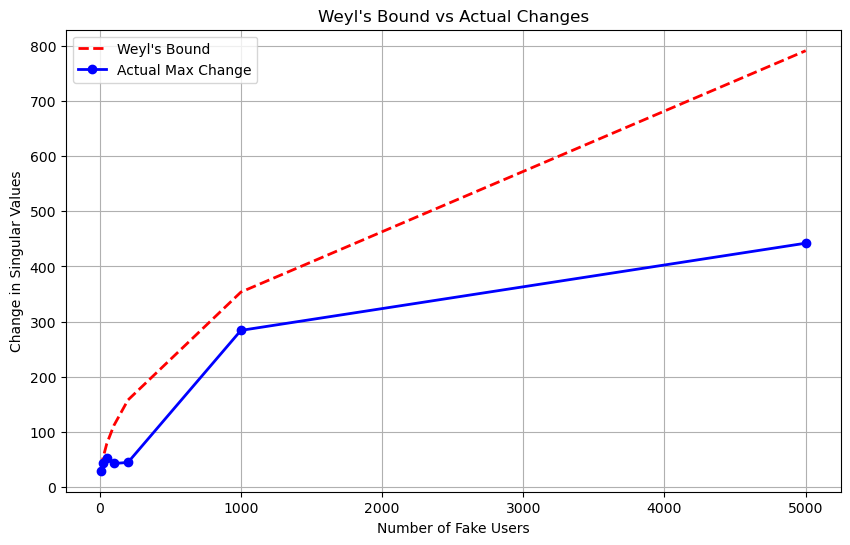

In [173]:
plt.figure(figsize=(10, 6))

# Plot Weyl's bounds
plt.plot([r['num_users'] for r in results], 
         [r['weyl_bound'] for r in results], 
         'r--', label='Weyl\'s Bound', linewidth=2)

# Plot actual max changes
plt.plot([r['num_users'] for r in results], 
         [r['max_change'] for r in results], 
         'b-o', label='Actual Max Change', linewidth=2)

plt.xlabel('Number of Fake Users')
plt.ylabel('Change in Singular Values')
plt.title('Weyl\'s Bound vs Actual Changes')
plt.legend()
plt.grid(True)

plt.show()